<a href="https://colab.research.google.com/github/andryll/MGR-IC/blob/main/codes/ClassificationTestes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importando as Bibliotecas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
import random
from collections import Counter
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

### Algoritmos

In [9]:
def KFoldCrossValidation(dataframe, n_splits, seed):

    X_columns = dataframe.columns[dataframe.columns != 'Classe']
    X = dataframe[X_columns]
    Y = dataframe['Classe']

    skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state = seed)

    X_train_list = []
    X_test_list = []
    Y_train_list = []
    Y_test_list = []

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Armazenar os vetores de treino e teste nas listas
        X_train_list.append(X_train.values.tolist())
        X_test_list.append(X_test.values.tolist())
        Y_train_list.append(Y_train.to_list())
        Y_test_list.append(Y_test.to_list())

    return X_train_list, X_test_list, Y_train_list, Y_test_list

In [43]:
def BlockSplit0(dataframe, n_splits, seed, n_songs):

  random.seed(seed)
  n_block = round(dataframe.shape[0] / n_songs)
  songs_per_genre = round(n_songs/10)
  n_test = round(songs_per_genre * 0.1)

  test_list = []
  definitive_test_list = []


  for i in range(10):
    r = random.sample(range(i*songs_per_genre, (i+1)*songs_per_genre), n_test)
    for j in r:
      test_list.append(j)

  test_list.sort()
  for i in test_list:
    for j in range(n_block):
      definitive_test_list.append(round((i*n_block)+j))

  return definitive_test_list

In [44]:
def BlockSplit(dataframe, seed, n_songs):


  random.seed(seed)
  n_block = round(dataframe.shape[0] / n_songs)
  songs_per_genre = round(n_songs/10)
  n_test = round(songs_per_genre * 0.1)

  #used_list = []
  range_list = []
  block_lists = []

  for i in range(10):
    range_list.append(range(i*songs_per_genre, (i+1)*songs_per_genre))

  for k in range(10):
    test_list = []
    definitive_test_list = []

    for i in range(10):
      r = random.sample(range_list[i], n_test)
      #print(range_list[i])
      range_list[i] = [element for element in range_list[i] if element not in r]

      for j in r:
        test_list.append(j)

    test_list.sort()
    #print(test_list)
    for i in test_list:
      for j in range(n_block):
        definitive_test_list.append(round((i*n_block)+j))

    #print(definitive_test_list)
    block_lists.append(definitive_test_list)

  return block_lists

In [11]:
def blockBalancedScore(Y_real, Y_predict, n_songs):

  #print(type(Y_real))

  n_samples = len(Y_predict)
  samples_per_song = (n_samples*10)/n_songs

  block_predict = []
  block_true = []

  # print('N_songs:', n_songs)
  # print('N_samples:', len(Y_predict))
  # print('samples_per_song:', samples_per_song)

  predict_groups = [Y_predict[i:i+int(samples_per_song)] for i in range(0, n_samples, int(samples_per_song))]

  for group in predict_groups:
    count = Counter(group)
    block_predict.append(count.most_common(1)[0][0])

  indexes = range(0, n_samples, int(samples_per_song))
  block_true = Y_real.iloc[indexes].tolist()

  return balanced_accuracy_score(block_true, block_predict)

In [12]:
def elbowKNN(dflist, n_neigh, seed, n_songs):


  scorelist = []

  for df in dflist:
    neigh = neighbors.KNeighborsClassifier(n_neighbors= n_neigh)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    neigh.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict = neigh.predict(X.iloc[X.index.isin(test),:])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [13]:
def elbowTree(dflist, seed, n_songs):

  scorelist = []

  for df in dflist:
    clf = tree.DecisionTreeClassifier(random_state = seed)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    clf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict = clf.predict(X.iloc[X.index.isin(test),:])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [14]:
def elbowRF(dflist, seed, n_songs):

  scorelist = []

  for df in dflist:
    rf = ensemble.RandomForestClassifier(random_state = seed)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    rf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict = rf.predict(X.iloc[X.index.isin(test),:])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [69]:
def elbowAll(dflist, seed, n_songs):
  scorelistKNN = []
  scorelistDT = []
  scorelistRF = []
  scorelistSVM = []
  scorelistXGB = []
  scorelistMLP = []
  scorelistLR = []

  scorelistKNNB = []
  scorelistDTB = []
  scorelistRFB = []
  scorelistSVMB = []
  scorelistXGBB = []
  scorelistMLPB = []
  scorelistLRB = []

  for df in dflist:


    scorelistKNN_t = []
    scorelistDT_t = []
    scorelistRF_t = []
    scorelistSVM_t = []
    scorelistXGB_t = []
    scorelistMLP_t = []
    scorelistLR_t = []

    scorelistKNNB_t = []
    scorelistDTB_t = []
    scorelistRFB_t = []
    scorelistSVMB_t = []
    scorelistXGBB_t = []
    scorelistMLPB_t = []
    scorelistLRB_t = []


    df['Classe'] = pd.Categorical(df['Classe'])
    df['Classe'] = df['Classe'].cat.codes

    neigh = neighbors.KNeighborsClassifier()
    clf = tree.DecisionTreeClassifier(random_state = seed)
    rf = ensemble.RandomForestClassifier(random_state = seed)
    svmc = svm.SVC(random_state=seed)
    xgbc = xgb.XGBClassifier(objective='multi:softprob', random_state=seed)
    mlp = MLPClassifier(random_state=seed)
    lr = LogisticRegression(random_state=seed, max_iter=300)

    test_list = BlockSplit(df, seed = seed, n_songs=n_songs)
    scaler = MinMaxScaler()

    df = df.drop(columns=['tempo1', 'tempo2', 'tempo3'])
    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]

    X = pd.DataFrame(scaler.fit_transform(X.loc[:,:]), columns=X.columns)

    Y = df['Classe']

    for test in test_list:

      neigh.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predict3 = neigh.predict(X.iloc[X.index.isin(test),:])

      clf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictDT = clf.predict(X.iloc[X.index.isin(test),:])

      rf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictRF = rf.predict(X.iloc[X.index.isin(test),:])

      svmc.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictSVM = svmc.predict(X.iloc[X.index.isin(test),:])

      xgbc.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictXGB = xgbc.predict(X.iloc[X.index.isin(test),:])

      mlp.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictMLP = mlp.predict(X.iloc[X.index.isin(test),:])

      lr.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictLR = lr.predict(X.iloc[X.index.isin(test),:])


      scorelistKNN_t.append(balanced_accuracy_score(Y.iloc[test], Y_predict3))
      scorelistDT_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictDT))
      scorelistRF_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictRF))
      scorelistSVM_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictSVM))
      scorelistXGB_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictXGB))
      scorelistMLP_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictMLP))
      scorelistLR_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictLR))

      scorelistKNNB_t.append(blockBalancedScore(Y.iloc[test], Y_predict3, n_songs))
      scorelistDTB_t.append(blockBalancedScore(Y.iloc[test], Y_predictDT, n_songs))
      scorelistRFB_t.append(blockBalancedScore(Y.iloc[test], Y_predictRF, n_songs))
      scorelistSVMB_t.append(blockBalancedScore(Y.iloc[test], Y_predictSVM, n_songs))
      scorelistXGBB_t.append(blockBalancedScore(Y.iloc[test], Y_predictXGB, n_songs))
      scorelistMLPB_t.append(blockBalancedScore(Y.iloc[test], Y_predictMLP, n_songs))
      scorelistLRB_t.append(blockBalancedScore(Y.iloc[test], Y_predictLR, n_songs))

    scorelistKNN.append(np.mean(scorelistKNN_t, axis=0))
    scorelistDT.append(np.mean(scorelistDT_t, axis=0))
    scorelistRF.append(np.mean(scorelistRF_t, axis=0))
    scorelistSVM.append(np.mean(scorelistSVM_t, axis=0))
    scorelistXGB.append(np.mean(scorelistXGB_t, axis=0))
    scorelistMLP.append(np.mean(scorelistMLP_t, axis=0))
    scorelistLR.append(np.mean(scorelistLR_t, axis=0))

    scorelistKNNB.append(np.mean(scorelistKNNB_t, axis=0))
    scorelistDTB.append(np.mean(scorelistDTB_t, axis=0))
    scorelistRFB.append(np.mean(scorelistRFB_t, axis=0))
    scorelistSVMB.append(np.mean(scorelistSVMB_t, axis=0))
    scorelistXGBB.append(np.mean(scorelistXGBB_t, axis=0))
    scorelistMLPB.append(np.mean(scorelistMLPB_t, axis=0))
    scorelistLRB.append(np.mean(scorelistLRB_t, axis=0))



  return scorelistKNN, scorelistDT, scorelistRF, scorelistSVM, scorelistXGB, scorelistMLP, scorelistLR, scorelistKNNB, scorelistDTB, scorelistRFB, scorelistSVMB, scorelistXGBB, scorelistMLPB, scorelistLRB

### Testes

In [75]:
#Ler CSVs
dflist = []

csvnames = ['256.csv', '512.csv','1024.csv','2048.csv','4096.csv','8192.csv']

for i in csvnames:
  dir_path = os.path.join('F:/Documentos/UTFPR/IC/csvs/ft3/3s', i)
  dflist.append(pd.read_csv(dir_path, sep=',', encoding='utf-8'))


In [47]:
dflist[1].head()

,Chroma mean C,Chroma sd2 C,Chroma mean C#,Chroma sd2 C#,Chroma mean D,Chroma sd2 D,Chroma mean D#,Chroma sd2 D#,Chroma mean E,Chroma sd2 E,...,MFCC7 mean,MFCC7 sd2,MFCC8 mean,MFCC8 sd2,MFCC9 mean,MFCC9 sd2,MFCC10 mean,MFCC10 sd2,tempo,Classe
0,0.412093,0.109936,0.460608,0.096704,0.484695,0.104980,0.357000,0.066946,0.367279,0.076532,...,18.325016,70.441100,-14.574311,77.09913,13.269976,81.84498,-2.177459,73.141920,124.529367,blues
1,0.376765,0.092698,0.393495,0.075831,0.496074,0.103010,0.353649,0.059327,0.337140,0.066783,...,15.487544,80.382740,-13.480688,84.06375,12.660768,72.02704,-2.417996,53.554302,124.529367,blues
2,0.405728,0.109972,0.406437,0.093525,0.475206,0.104613,0.310911,0.059642,0.279308,0.055110,...,16.907660,67.990200,-17.028122,63.81894,11.769398,80.49942,-3.216142,69.805600,124.529367,blues
3,0.613069,0.126739,0.499344,0.097389,0.495903,0.089821,0.351228,0.057980,0.324322,0.052651,...,14.706237,149.004520,-7.499419,256.69485,16.919321,98.86162,6.477136,74.154366,104.403409,blues
4,0.399145,0.112249,0.378123,0.095132,0.409525,0.105325,0.377179,0.092366,0.386116,0.069363,...,23.463932,120.450676,-13.849482,231.93430,19.525587,125.32860,1.340928,83.776710,104.403409,blues


In [76]:
# Executa os algoritmos com as features desejadas e salva os valores de score nas listas

knnscores = []
dtscores = []
rfscores = []
svmscores = []
xgbscores = []
mlpscores = []
lrscores = []

knnscoresB = []
dtscoresB = []
rfscoresB = []
svmscoresB = []
xgbscoresB = []
mlpscoresB = []
lrscoresB = []

seeds = [14, 42, 60, 87, 113, 156, 211, 456, 917, 1001]
# seeds = [14, 42, 60]


# for seed in seeds:
#   knnscores3.append(elbowKNN(dflist, n_neigh = 3, seed = seed, n_songs=500))
#   knnscores5.append(elbowKNN(dflist, n_neigh = 5, seed = seed, n_songs=500))
#   knnscores7.append(elbowKNN(dflist, n_neigh = 7, seed = seed, n_songs=500))

#   dtscores.append(elbowTree(dflist, seed = seed, n_songs=500))
#   rfscores.append(elbowRF(dflist, seed = seed, n_songs=500))

for seed in seeds:
  knn, dt, rf, svmc, xgbc, mlp, lr, knnB, dtB, rfB, svmcB, xgbcB, mlpB, lrB = elbowAll(dflist, seed = seed, n_songs=1000)

  knnscores.append(knn)
  dtscores.append(dt)
  rfscores.append(rf)
  svmscores.append(svmc)
  xgbscores.append(xgbc)
  mlpscores.append(mlp)
  lrscores.append(lr)

  knnscoresB.append(knnB)
  dtscoresB.append(dtB)
  rfscoresB.append(rfB)
  svmscoresB.append(svmcB)
  xgbscoresB.append(xgbcB)
  mlpscoresB.append(mlpB)
  lrscoresB.append(lrB)

A saída de streaming foi truncada nas últimas 5000 linhas.
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\andry\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization ha

In [77]:
# Coloca as listas de score em uma outra lista a cria listas com as médias e os sds.

scoreslist = []
scoresmeans = []
scoressds = []

scoreslistB = []
scoresmeansB = []
scoressdsB = []

scoreslist.append(np.array(knnscores))
scoreslist.append(np.array(dtscores))
scoreslist.append(np.array(rfscores))
scoreslist.append(np.array(svmscores))
scoreslist.append(np.array(xgbscores))
scoreslist.append(np.array(mlpscores))
scoreslist.append(np.array(lrscores))


scoreslistB.append(np.array(knnscoresB))
scoreslistB.append(np.array(dtscoresB))
scoreslistB.append(np.array(rfscoresB))
scoreslistB.append(np.array(svmscoresB))
scoreslistB.append(np.array(xgbscoresB))
scoreslistB.append(np.array(mlpscoresB))
scoreslistB.append(np.array(lrscoresB))


# KNN3 = 0 / KNN5 = 1 / KNN7 = 2 / DT = 3 / RF = 4

for score in scoreslist:
  scoresmeans.append(np.mean(score, axis=0))
  scoressds.append(np.std(score, axis=0))

for score in scoreslistB:
  scoresmeansB.append(np.mean(score, axis=0))
  scoressdsB.append(np.std(score, axis=0))

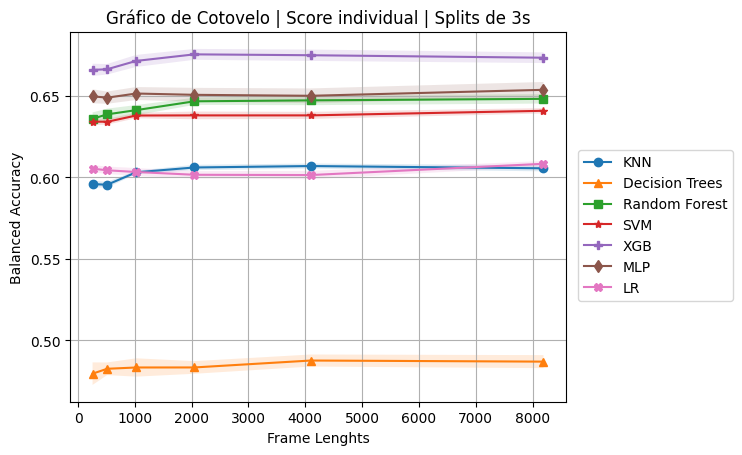

In [78]:
#  Plota o gráfico com as médias das seeds e os desvios padrão

frame_lenghts = [256, 512, 1024, 2048, 4096, 8192]
labels = ['KNN', 'Decision Trees', 'Random Forest', 'SVM', 'XGB', 'MLP', 'LR']
markers = ['o', '^', 's', '*', 'P', 'd', 'X']

for i in range(len(scoresmeans)):
  plt.plot(frame_lenghts, scoresmeans[i], label = labels[i], marker = markers[i])
  plt.fill_between(frame_lenghts, scoresmeans[i] + scoressds[i], scoresmeans[i] - scoressds[i], alpha = 0.15)

plt.legend( bbox_to_anchor = (1.35, 0.7))
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Gráfico de Cotovelo | Score individual | Splits de 3s')

# Nome do arquivo pra salvar
plt.savefig('F:/Documentos/UTFPR/IC/csvs/ft3/3s/score_simples.pdf')
plt.show()

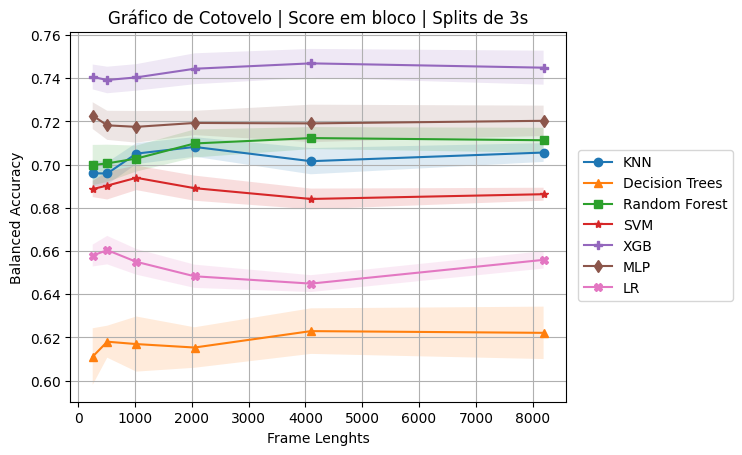

In [79]:
#  Plota o gráfico com as médias das seeds e os desvios padrão

frame_lenghts = [256, 512, 1024, 2048, 4096, 8192]
labels = ['KNN', 'Decision Trees', 'Random Forest', 'SVM', 'XGB', 'MLP', 'LR']
markers = ['o', '^', 's', '*', 'P', 'd', 'X']

for i in range(len(scoresmeansB)):
  plt.plot(frame_lenghts, scoresmeansB[i], label = labels[i], marker = markers[i])
  plt.fill_between(frame_lenghts, scoresmeansB[i] + scoressdsB[i], scoresmeansB[i] - scoressdsB[i], alpha = 0.15)

plt.legend(bbox_to_anchor = (1.35, 0.7))
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Gráfico de Cotovelo | Score em bloco | Splits de 3s')

# Nome do arquivo pra salvar
plt.savefig('F:/Documentos/UTFPR/IC/csvs/ft3/3s/score_bloco.pdf')
plt.show()

In [ ]:
means_3s_ind = []
means_3s_ind.append(scoresmeans)
means_3s_b = []
means_3s_b.append(scoresmeansB)

In [ ]:
print(means_3s_b)
print(means_3s_ind)
print(means_5s_ind)
print(means_5s_b)
print(means_10s_ind)
print(means_10s_b)

[[array([0.7  , 0.699, 0.698, 0.704, 0.699, 0.705]), array([0.606, 0.587, 0.624, 0.59 , 0.629, 0.63 ]), array([0.74 , 0.736, 0.743, 0.746, 0.727, 0.735]), array([0.754, 0.753, 0.753, 0.751, 0.744, 0.751]), array([0.779, 0.782, 0.786, 0.79 , 0.784, 0.777]), array([0.754, 0.767, 0.767, 0.769, 0.764, 0.769]), array([0.721, 0.725, 0.728, 0.728, 0.734, 0.743])]]
[[array([0.574 , 0.5721, 0.5731, 0.5783, 0.5803, 0.5741]), array([0.4748, 0.4656, 0.4843, 0.4775, 0.4896, 0.487 ]), array([0.6687, 0.6658, 0.6739, 0.6725, 0.6667, 0.6674]), array([0.6789, 0.6786, 0.6792, 0.6839, 0.6791, 0.6859]), array([0.7009, 0.7015, 0.7112, 0.7134, 0.7041, 0.7063]), array([0.6843, 0.6847, 0.6847, 0.6868, 0.687 , 0.691 ]), array([0.6595, 0.6605, 0.6591, 0.6605, 0.6596, 0.6674])]]
[[array([0.60533333, 0.60533333, 0.60783333, 0.61783333, 0.61216667,
       0.613     ]), array([0.491     , 0.48966667, 0.496     , 0.49566667, 0.49883333,
       0.50133333]), array([0.679     , 0.681     , 0.68533333, 0.69066667, 0.681

In [ ]:
ind_3s = [elemento for array in means_3s_ind[0] for elemento in array]
b_3s = [elemento for array in means_3s_b[0] for elemento in array]

ind_5s = [elemento for array in means_5s_ind[0] for elemento in array]
b_5s = [elemento for array in means_5s_b[0] for elemento in array]

ind_10s = [elemento for array in means_10s_ind[0] for elemento in array]
b_10s = [elemento for array in means_10s_b[0] for elemento in array]


NameError: name 'means_3s_ind' is not defined

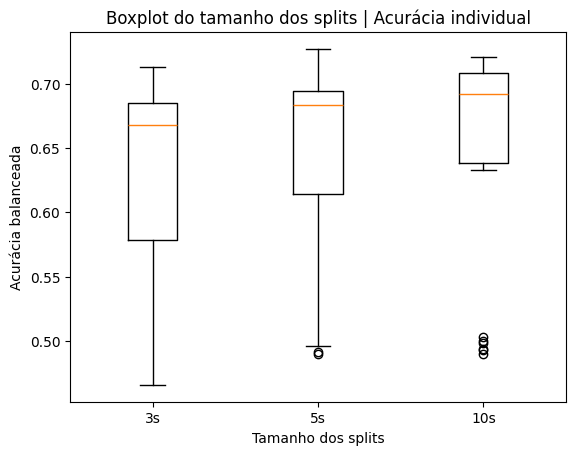

In [ ]:
plt.boxplot([ind_3s, ind_5s, ind_10s], labels=["3s", "5s", "10s"])
plt.xlabel("Tamanho dos splits")
plt.ylabel("Acurácia balanceada")
plt.title("Boxplot do tamanho dos splits | Acurácia individual")
plt.savefig('boxplot_splits.pdf')
plt.show()

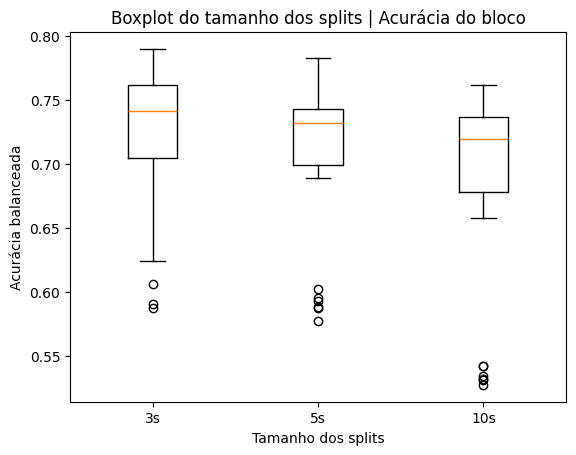

In [ ]:
plt.boxplot([b_3s, b_5s, b_10s], labels=["3s", "5s", "10s"])
plt.xlabel("Tamanho dos splits")
plt.ylabel("Acurácia balanceada")
plt.title("Boxplot do tamanho dos splits | Acurácia do bloco")
plt.savefig('boxplot_splits_b.pdf')
plt.show()

In [ ]:
fls_ind = [[lista[i] for lista in means_3s_ind[0]] for i in range(6)]
fls_b = [[lista[i] for lista in means_3s_b[0]] for i in range(6)]

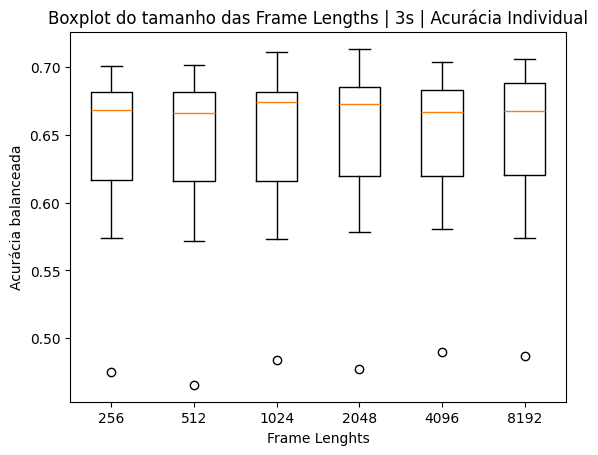

In [ ]:
plt.boxplot(fls_ind, labels=["256", "512", "1024", "2048", "4096", "8192"])
plt.xlabel("Frame Lenghts")
plt.ylabel("Acurácia balanceada")
plt.title("Boxplot do tamanho das Frame Lengths | 3s | Acurácia Individual")
plt.savefig('boxplot_fl3.pdf')
plt.show()

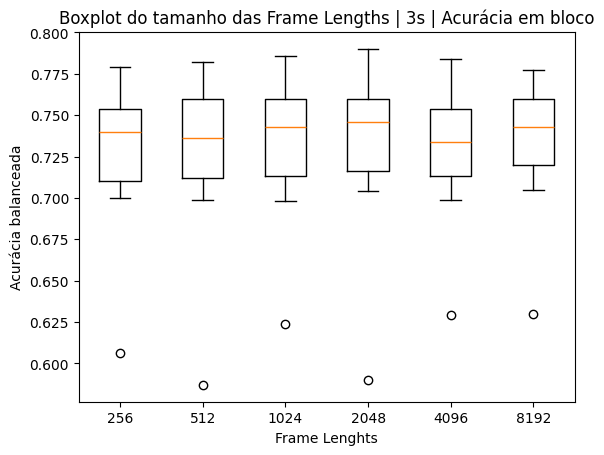

In [ ]:
plt.boxplot(fls_b, labels=["256", "512", "1024", "2048", "4096", "8192"])
plt.xlabel("Frame Lenghts")
plt.ylabel("Acurácia balanceada")
plt.title("Boxplot do tamanho das Frame Lengths | 3s | Acurácia em bloco")
plt.savefig('boxplot_fl3b.pdf')
plt.show()

In [ ]:
from scipy.stats import wilcoxon

statistic, p_value = wilcoxon(np.array(ind_3s), np.array(ind_5s))

# Exiba os resultados
print(f"Estatística do teste de Wilcoxon | 3s - 5s: {statistic}")
print(f"Valor p: {p_value}")

# Verifique se a diferença é estatisticamente significativa
alpha = 0.05
if p_value < alpha:
    print("Há evidência estatística de diferença significativa.")
else:
    print("Não há evidência estatística de diferença significativa.")

Estatística do teste de Wilcoxon | 3s - 5s: 0.0
Valor p: 4.547473508864641e-13
Há evidência estatística de diferença significativa.


In [ ]:

statistic, p_value = wilcoxon(np.array(ind_3s), np.array(ind_10s))

# Exiba os resultados
print(f"Estatística do teste de Wilcoxon | 3s - 10s: {statistic}")
print(f"Valor p: {p_value}")

# Verifique se a diferença é estatisticamente significativa
alpha = 0.05
if p_value < alpha:
    print("Há evidência estatística de diferença significativa.")
else:
    print("Não há evidência estatística de diferença significativa.")

Estatística do teste de Wilcoxon | 3s - 10s: 0.0
Valor p: 4.547473508864641e-13
Há evidência estatística de diferença significativa.


In [ ]:

statistic, p_value = wilcoxon(np.array(ind_5s), np.array(ind_10s))

# Exiba os resultados
print(f"Estatística do teste de Wilcoxon | 5s - 10s: {statistic}")
print(f"Valor p: {p_value}")

# Verifique se a diferença é estatisticamente significativa
alpha = 0.05
if p_value < alpha:
    print("Há evidência estatística de diferença significativa.")
else:
    print("Não há evidência estatística de diferença significativa.")

Estatística do teste de Wilcoxon | 5s - 10s: 38.0
Valor p: 3.6529109078762475e-07
Há evidência estatística de diferença significativa.


In [ ]:
dfbox = pd.DataFrame({'3s individual': ind_3s, '5s individual': ind_5s, '10s individual': ind_10s, '3s em bloco': b_3s, '5s em bloco': b_5s, '10s em bloco': b_10s})

In [ ]:
dfbox.head()
dfbox.to_csv('boxplot_values.csv', index=False)

In [20]:
test_blocks = BlockSplit2(dflist[0], 5, 42, 10)

In [21]:
print(test_blocks)

[[], [], [], [], [], [], [], [], [], []]
